# Large-scale Document Retrieval with ElasticSearch
> A tutorial to understand the process of retrieving documents/items using elastic search and vector indexing methods.

- toc: true
- badges: true
- comments: true
- categories: [elasticsearch, jupyter]
- image: 

## Retrieval Flow Overview

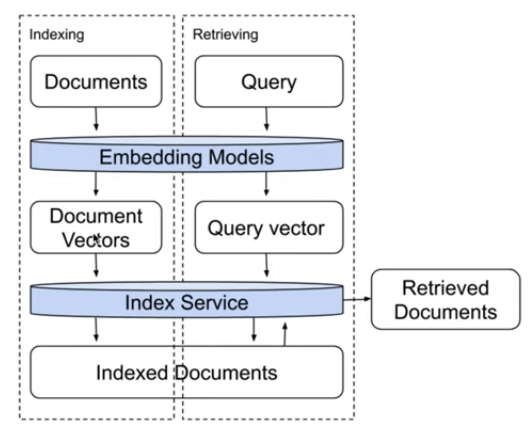

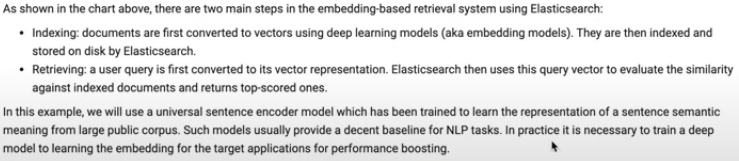

## Part 1 - Setting up Elasticsearch
- Download the elasticsearch archive (linux), setup a local server
- Create a client connection to the local elasticsearch instance

In [ ]:
# download the latest elasticsearch version
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.11.1-linux-x86_64.tar.gz
!tar -xzvf elasticsearch-7.11.1-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.11.1

# prep the elasticsearch server
import os
from subprocess import Popen, PIPE, STDOUT
es_subprocess = Popen(['elasticsearch-7.11.1/bin/elasticsearch'], stdout=PIPE, stderr=STDOUT, preexec_fn=lambda : os.setuid(1))

# wait for a few minutes for the local host to start
!curl -X GET "localhost:9200/"

# install elasticsearch python api
!pip install -q elasticsearch

{
  "name" : "50176241ce38",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "WQS1QVG8RX6FQ65LS6MyrA",
  "version" : {
    "number" : "7.11.1",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "ff17057114c2199c9c1bbecc727003a907c0db7a",
    "build_date" : "2021-02-15T13:44:09.394032Z",
    "build_snapshot" : false,
    "lucene_version" : "8.7.0",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [ ]:
# check if elasticsearch server is properly running in the background
from elasticsearch import Elasticsearch, helpers
es_client = Elasticsearch(['localhost'])
es_client.info()

{'cluster_name': 'elasticsearch',
 'cluster_uuid': 'WQS1QVG8RX6FQ65LS6MyrA',
 'name': '50176241ce38',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2021-02-15T13:44:09.394032Z',
  'build_flavor': 'default',
  'build_hash': 'ff17057114c2199c9c1bbecc727003a907c0db7a',
  'build_snapshot': False,
  'build_type': 'tar',
  'lucene_version': '8.7.0',
  'minimum_index_compatibility_version': '6.0.0-beta1',
  'minimum_wire_compatibility_version': '6.8.0',
  'number': '7.11.1'}}

## Part 2 - Walking through an embedding-based retrieval system


### Download MovieLens dataset

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-25m.zip --no-check-certificate
!unzip ml-25m.zip

Archive:  ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       


In [ ]:
import pandas as pd
data = pd.read_csv('ml-25m/movies.csv').drop_duplicates()
data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Build index with document vectors

In [ ]:
import tensorflow_hub as hub
from timeit import default_timer as timer
import json

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [ ]:
# constants
INDEX_NAME = "movie_title"
BATCH_SIZE = 200
SEARCH_SIZE = 10
MAPPINGS = {
    'mappings': {'_source': {'enabled': 'true'},
                 'dynamic': 'true',
                 'properties': {'title_vector':
                                {'dims': 512, 'type': 'dense_vector'},
                                'movie_id': {'type': 'keyword'},
                                'genres': {'type': 'keyword'}
                                }
                 },
            'settings': {'number_of_replicas': 1, 'number_of_shards':2}
}

In [ ]:
def index_movie_lens(df, num_doc=500):
  print('creating the {} index.'.format(INDEX_NAME))
  es_client.indices.delete(index=INDEX_NAME, ignore=[404])
  es_client.indices.create(index=INDEX_NAME, body=json.dumps(MAPPINGS))

  requests = []
  count = 0
  start = timer()

  for row_index, doc in df.iterrows():

    # specify the index size to avoid long waiting time
    if count >= num_doc:
      break
    
    # construct requests
    if len(requests) < BATCH_SIZE:

      title_text = doc.title
      genres_text = doc.genres
      title_vector = embed([title_text]).numpy().tolist()[0]

      request = {
          "op_type": "index",
          "_index": INDEX_NAME,
          "_id": row_index,
          "title": title_text,
          "genres": genres_text,
          "title_vector": title_vector,
          "movie_id": doc.movieId
      }

      requests.append(request)
    
    else:
      helpers.bulk(es_client, requests)
      count += len(requests)
      requests.clear()
      if count % (BATCH_SIZE * 2) == 0:
        print("Indexed {} documents in {:.2f} seconds.".format(count, timer()-start))
    
  # Index the remaining
  helpers.bulk(es_client, requests)
  end = timer()

  print("Done indexing {} documents in {:.2f} seconds".format(count, end-start))

Ref - https://youtu.be/F4D08uU3mPA

In [ ]:
index_movie_lens(data, num_doc=2000)

creating the movie_title index.
Indexed 400 documents in 27.59 seconds.
Indexed 800 documents in 48.96 seconds.
Indexed 1200 documents in 70.18 seconds.
Indexed 1600 documents in 90.92 seconds.
Indexed 2000 documents in 111.85 seconds.
Done indexing 2000 documents in 111.85 seconds


### Search with query vector

In [ ]:
def return_top_movies(query):

  embedding_start = timer()
  query_vector = embed([query]).numpy().tolist()[0]
  embedding_time = timer() - embedding_start
  formula = "cosineSimilarity(params.query_vector, 'title_vector') + 1.0"

  script_query = {
      "script_score": {
          "query": {"match_all": {}},
          "script": {
              "source": formula,
              "params": {"query_vector": query_vector}
          }
      }
  }

  search_start = timer()
  response = es_client.search(
      index=INDEX_NAME,
      body={
          "size":SEARCH_SIZE,
          "query": script_query,
          "_source": {"includes": ["title", "genres"]}
      }
  )
  search_time = timer() - search_start

  print()
  print("{} total hits.".format(response["hits"]["total"]["value"]))
  
  for hit in response["hits"]["hits"]:

    print("id: {}, score: {}".format(hit["_id"], hit["_score"] - 1))
    print(hit["_source"])
    print()

In [ ]:
return_top_movies("war")


2000 total hits.
id: 335, score: 0.5282537
{'genres': 'Adventure|Drama|War', 'title': 'War, The (1994)'}

id: 712, score: 0.43743240000000005
{'genres': 'Documentary', 'title': 'War Stories (1995)'}

id: 1493, score: 0.3954858000000001
{'genres': 'Drama', 'title': 'War at Home, The (1996)'}

id: 1362, score: 0.32700850000000004
{'genres': 'Romance|War', 'title': 'In Love and War (1996)'}

id: 550, score: 0.3104720000000001
{'genres': 'Documentary', 'title': 'War Room, The (1993)'}

id: 1828, score: 0.30568780000000007
{'genres': 'Action|Romance|Sci-Fi|Thriller', 'title': 'Armageddon (1998)'}

id: 1932, score: 0.3055576
{'genres': 'Adventure|Sci-Fi', 'title': 'Dune (1984)'}

id: 1265, score: 0.2961224
{'genres': 'Drama|War', 'title': 'Killing Fields, The (1984)'}

id: 1063, score: 0.2951368999999999
{'genres': 'Drama|War', 'title': 'Platoon (1986)'}

id: 1676, score: 0.2776048
{'genres': 'Comedy', 'title': 'Senseless (1998)'}



## Part 3 - Approximate Nearest Neighbor (ANN) Algorithms

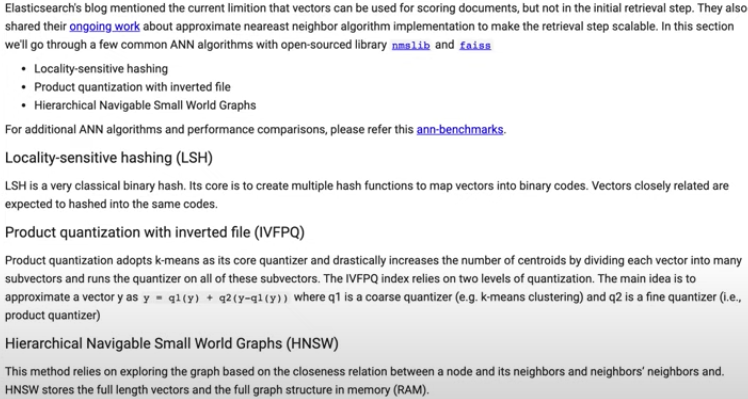

In [ ]:
#hide_output
!pip install faiss
!pip install nmslib
!apt-get install libomp-dev

import faiss
import nmslib

     |████████████████████████████████| 4.7MB 5.0MB/s 
     |████████████████████████████████| 13.5MB 259kB/s 
     |████████████████████████████████| 194kB 31.3MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 29 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 2s (141 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpackin

In [ ]:
documents = data['title'].to_list()[:2000]
# # OOM for large document size
embeddings = embed(documents).numpy()
embeddings.shape

(2000, 512)

In [ ]:
class DemoIndexLSH():
  def __init__(self, dimension, documents, embeddings):
    self.dimension = dimension
    self.documents = documents
    self.embeddings = embeddings

  def build(self, num_bits=8):
    self.index = faiss.IndexLSH(self.dimension, num_bits)
    self.index.add(self.embeddings)

  def query(self, input_embedding, k=5):
    distances, indices = self.index.search(input_embedding, k)

    return [(distance, self.documents[index]) for distance, index in zip(distances[0], indices[0])]

index_lsh = DemoIndexLSH(512, documents, embeddings)
index_lsh.build(num_bits=16)

In [ ]:
class DemoIndexIVFPQ():
  def __init__(self, dimension, documents, embeddings):
    self.dimension = dimension
    self.documents = documents
    self.embeddings = embeddings

  def build(self,
            number_of_partition=2,
            number_of_subquantizers=2,
            subvector_bits=4):
    quantizer = faiss.IndexFlatL2(self.dimension)
    self.index = faiss.IndexIVFPQ(quantizer, 
                                  self.dimension,
                                  number_of_partition,
                                  number_of_subquantizers,
                                  subvector_bits)
    self.index.train(self.embeddings)
    self.index.add(self.embeddings)

  def query(self, input_embedding, k=5):
    distances, indices = self.index.search(input_embedding, k)

    return [(distance, self.documents[index]) for distance, index in zip(distances[0], indices[0])]

index_pq = DemoIndexIVFPQ(512, documents, embeddings)
index_pq.build()

In [ ]:
class DemoHNSW():
  def __init__(self, dimension, documents, embeddings):
    self.dimension = dimension
    self.documents = documents
    self.embeddings = embeddings

  def build(self, num_bits=8):
    self.index = nmslib.init(method='hnsw', space='cosinesimil')
    self.index.addDataPointBatch(self.embeddings)
    self.index.createIndex({'post': 2}, print_progress=True)

  def query(self, input_embedding, k=5):
    indices, distances = self.index.knnQuery(input_embedding, k)

    return [(distance, self.documents[index]) for distance, index in zip(distances, indices)]

index_hnsw = DemoHNSW(512, documents, embeddings)
index_hnsw.build()

In [ ]:
class DemoIndexFlatL2():
  def __init__(self, dimension, documents, embeddings):
    self.dimension = dimension
    self.documents = documents
    self.embeddings = embeddings

  def build(self, num_bits=8):
    self.index = faiss.IndexFlatL2(self.dimension)
    self.index.add(self.embeddings)

  def query(self, input_embedding, k=5):
    distances, indices = self.index.search(input_embedding, k)

    return [(distance, self.documents[index]) for distance, index in zip(distances[0], indices[0])]

index_flat = DemoIndexFlatL2(512, documents, embeddings)
index_flat.build()

In [ ]:
def return_ann_top_movies(ann_index, query, k=SEARCH_SIZE):
  query_vector = embed([query]).numpy()
  search_start = timer()
  top_docs = ann_index.query(query_vector, k)
  search_time = timer() - search_start
  print("search time: {:.2f} ms".format(search_time * 1000))
  return top_docs

In [ ]:
return_ann_top_movies(index_flat, "romance")

search time: 0.82 ms


[(0.95573366, 'True Romance (1993)'),
 (1.2160163, 'Love Serenade (1996)'),
 (1.2626679, 'Love Affair (1994)'),
 (1.3447753, 'Kissed (1996)'),
 (1.3752131, 'In Love and War (1996)'),
 (1.3804029, 'Casablanca (1942)'),
 (1.3832319, 'Flirt (1995)'),
 (1.38626, 'Moonlight and Valentino (1995)'),
 (1.3862813, 'Hotel de Love (1996)'),
 (1.3907104, 'Intimate Relations (1996)')]

In [ ]:
return_ann_top_movies(index_lsh, "romance")

search time: 0.56 ms


[(2.0, 'Visitors, The (Visiteurs, Les) (1993)'),
 (2.0, 'City Hall (1996)'),
 (2.0, 'Paradise Road (1997)'),
 (3.0, 'When a Man Loves a Woman (1994)'),
 (3.0, 'Cosi (1996)'),
 (3.0, 'Haunted World of Edward D. Wood Jr., The (1996)'),
 (3.0, 'Eddie (1996)'),
 (3.0, 'Ransom (1996)'),
 (3.0, 'Time to Kill, A (1996)'),
 (3.0, 'Mirage (1995)')]

In [ ]:
return_ann_top_movies(index_pq, "romance")

search time: 0.19 ms


[(1.07124, 'Streetcar Named Desire, A (1951)'),
 (1.07124, 'Moonlight Murder (1936)'),
 (1.0847104, 'To Kill a Mockingbird (1962)'),
 (1.0847104, 'Meet John Doe (1941)'),
 (1.0867723, 'Moonlight and Valentino (1995)'),
 (1.0901785, 'Laura (1944)'),
 (1.0901785, 'Rebecca (1940)'),
 (1.0901785, 'African Queen, The (1951)'),
 (1.0901785, 'Gigi (1958)'),
 (1.0901785, 'Scarlet Letter, The (1926)')]

In [ ]:
return_ann_top_movies(index_hnsw, "romance")

search time: 0.29 ms


[(0.47786665, 'True Romance (1993)'),
 (0.6080081, 'Love Serenade (1996)'),
 (0.63133395, 'Love Affair (1994)'),
 (0.6723877, 'Kissed (1996)'),
 (0.6876065, 'In Love and War (1996)'),
 (0.6916158, 'Flirt (1995)'),
 (0.69312984, 'Moonlight and Valentino (1995)'),
 (0.69314075, 'Hotel de Love (1996)'),
 (0.69535506, 'Intimate Relations (1996)'),
 (0.6985383, 'Love in Bloom (1935)')]